# importowanie bibliotek, definiowanie funkcji

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.tsatools import lagmat
from statsmodels.regression.linear_model import RegressionResults
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.sandwich_covariance import cov_hc0, cov_hc1, cov_hc2, cov_hc3

pd.set_option('display.max_rows', None)

In [2]:
def calc_omega(alpha_g, beta_g):
    # wariancja bezwarunkowa = 1 => omega / (1 - alpha_g - beta_g) = 1 => omega = 1 - alpha_g - beta_g
    return 1 - alpha_g - beta_g

In [3]:
def generate_garch_resid(T, alpha_g, beta_g):
    """
    Generuje reszty z modelu GARCH(1,1) dla zadanych parametrów i długości T+1000 (aby mieć "burn-in").
    Nie usuwa żadnych obserwacji - to będzie zrobione później.
    """
    omega = calc_omega(alpha_g, beta_g)
    eps = np.zeros(T + 1000)
    sigma2 = np.zeros(T + 1000)

    # Inicjalne wartości
    sigma2[0] = 1.0
    eps[0] = np.random.normal(scale=np.sqrt(sigma2[0]))

    for t in range(1, T+1000):
        sigma2[t] = omega + alpha_g * eps[t-1]**2 + beta_g * sigma2[t-1]
        eps[t] = np.random.normal(scale=np.sqrt(sigma2[t]))
    return eps, sigma2

In [4]:
def generate_ar1(T, alpha0, alpha1, eps):
    """
    Generuje dane z AR(1) z zewnętrznie dostarczonym szumem eps.
    Nie usuwa pierwszych 1000 obserwacji.
    """
    x = np.zeros(T + 1000)
    x[0] = np.random.normal()
    for t in range(1, T+1000):
        x[t] = alpha0 + alpha1 * x[t-1] + eps[t-1]
    return x


In [5]:
def generate_ar1_normal(T, beta0, beta1):
    """
    Generuje dane z AR(1) z białym szumem N(0,1).
    Nie usuwa pierwszych 1000 obserwacji tutaj.
    """
    y = np.zeros(T + 1000)
    y[0] = np.random.normal()
    eps = np.random.normal(size=T+1000)
    for t in range(1, T+1000):
        y[t] = beta0 + beta1 * y[t-1] + eps[t-1]
    return y

# Symulacja

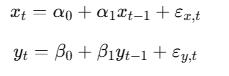

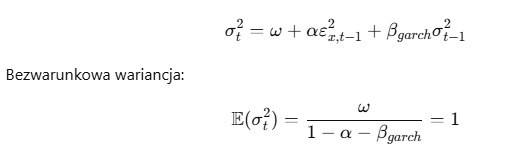

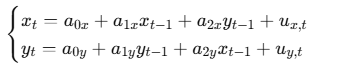

In [6]:
# Ustalanie parametrów
T_values = [50,100,1000]

alpha_0 = 0.0
beta_0 = 0.0

alpha1_values = [-0.8, -0.1, 0.1, 0.8]   # dla AR x
beta1_values = [-0.8, -0.1, 0.1, 0.8]    # dla AR y
alpha_g = 0.05                # stałe
beta_g_values = [0.1, 0.5, 0.9]    # zmienne wartości beta_g

results = []


In [88]:
for T in T_values:
  for alpha1 in alpha1_values:
      for beta1 in beta1_values:
          for beta_g in beta_g_values:

            result = 0

            for _ in range(1000):
                # 1. Generujemy reszty GARCH dla x
                eps_x, _ = generate_garch_resid(T, alpha_g, beta_g)

                # 2. Generujemy y z AR(1) z białym szumem
                y_full = generate_ar1_normal(T, beta_0, beta1)

                # 3. Generujemy x z AR(1) z eps_x wygenerowanymi z GARCH
                x_full = generate_ar1(T, alpha_0, alpha1, eps_x)

                # Usuwamy pierwsze 1000 obserwacji tuż przed dopasowaniem VAR
                x = x_full[1000:]
                y = y_full[1000:]

                # 4. Dopasowujemy model VAR(1)
                data = pd.DataFrame({'x': x, 'y': y})
                model = VAR(data)
                results_fit = model.fit(maxlags=1, trend='c')

                # 5. Testowanie przyczynowości Grangera
                #granger_test = grangercausalitytests(data[['x','y']], maxlag=1)
                #p_value = granger_test[1][0]['params_ftest'][1]

                coefficients = results_fit.params  # Macierz współczynników (z interceptami)
                pvalues = results_fit.pvalues  # p-wartości dla każdego współczynnika

                p_value_a12 = pvalues.loc['L1.x', 'y']

                # jeżeli p_value < 0.05 to wtedy odrzucamy H0, a zatem parametr w modelu VAR jest istotny => w modelu VAR występuje przyczynowość od y do x

                if(p_value_a12 < 0.05):
                  result += 1

                # Chcemy sprawdzić istotność parametru alfa 2 we wzorze x z VAR

                # Zapis wyników

               # results.append({
               #     'T': T,
               #     'alpha1_x': alpha1,
               #     'beta1_y': beta1,
               #     'alpha_g': alpha_g,
               #     'beta_g': beta_g,
               #     'p_value': p_value_a12
               # })
            results.append({
                'T': T,
                'alpha1_x': alpha1,
                'beta1_y': beta1,
                'alpha_g': alpha_g,
                'beta_g': beta_g,
                'result': result
            })
results_df = pd.DataFrame(results)
print(results_df)

        T  alpha1_x  beta1_y  alpha_g  beta_g  result
0      50      -0.8     -0.8     0.05     0.1      58
1      50      -0.8     -0.8     0.05     0.5      75
2      50      -0.8     -0.8     0.05     0.9      81
3      50      -0.8     -0.1     0.05     0.1      55
4      50      -0.8     -0.1     0.05     0.5      53
5      50      -0.8     -0.1     0.05     0.9      58
6      50      -0.8      0.1     0.05     0.1      50
7      50      -0.8      0.1     0.05     0.5      54
8      50      -0.8      0.1     0.05     0.9      57
9      50      -0.8      0.8     0.05     0.1      52
10     50      -0.8      0.8     0.05     0.5      46
11     50      -0.8      0.8     0.05     0.9      45
12     50      -0.1     -0.8     0.05     0.1      60
13     50      -0.1     -0.8     0.05     0.5      52
14     50      -0.1     -0.8     0.05     0.9      58
15     50      -0.1     -0.1     0.05     0.1      55
16     50      -0.1     -0.1     0.05     0.5      57
17     50      -0.1     -0.1

# interpretacja wyników

In [89]:
min_result = results_df['result'].min()
max_result = results_df['result'].max()

summary_table = pd.DataFrame({
    'Min result': [min_result],
    'Max result': [max_result]
})

print("Minimalna i maksymalna wartość result (liczba odrzuconych H0 na 1000 symulacji) w całym zbiorze danych:")
print(summary_table)


Minimalna i maksymalna wartość result (liczba odrzuconych H0 na 1000 symulacji) w całym zbiorze danych:
   Min result  Max result
0          41          89


In [90]:
rejections = results_df[results_df['result'] > 0]

if rejections.empty:
    print("Brak zestawów parametrów, przy których odrzucono H0")
else:
    print("Zestawy parametrów, dla których wystąpiło odrzucenie H0 (result > 0):")
    print(rejections[['T', 'alpha1_x', 'beta1_y', 'alpha_g', 'beta_g', 'result']])


Zestawy parametrów, dla których wystąpiło odrzucenie H0 (result > 0):
        T  alpha1_x  beta1_y  alpha_g  beta_g  result
0      50      -0.8     -0.8     0.05     0.1      58
1      50      -0.8     -0.8     0.05     0.5      75
2      50      -0.8     -0.8     0.05     0.9      81
3      50      -0.8     -0.1     0.05     0.1      55
4      50      -0.8     -0.1     0.05     0.5      53
5      50      -0.8     -0.1     0.05     0.9      58
6      50      -0.8      0.1     0.05     0.1      50
7      50      -0.8      0.1     0.05     0.5      54
8      50      -0.8      0.1     0.05     0.9      57
9      50      -0.8      0.8     0.05     0.1      52
10     50      -0.8      0.8     0.05     0.5      46
11     50      -0.8      0.8     0.05     0.9      45
12     50      -0.1     -0.8     0.05     0.1      60
13     50      -0.1     -0.8     0.05     0.5      52
14     50      -0.1     -0.8     0.05     0.9      58
15     50      -0.1     -0.1     0.05     0.1      55
16     50   

Wpływ parametru T na p-value testu

Średnia i odchylenie standardowe result w zależności od T:
      T       mean       std
0    50  59.437500  9.437152
1   100  52.958333  7.208028
2  1000  52.729167  6.933543


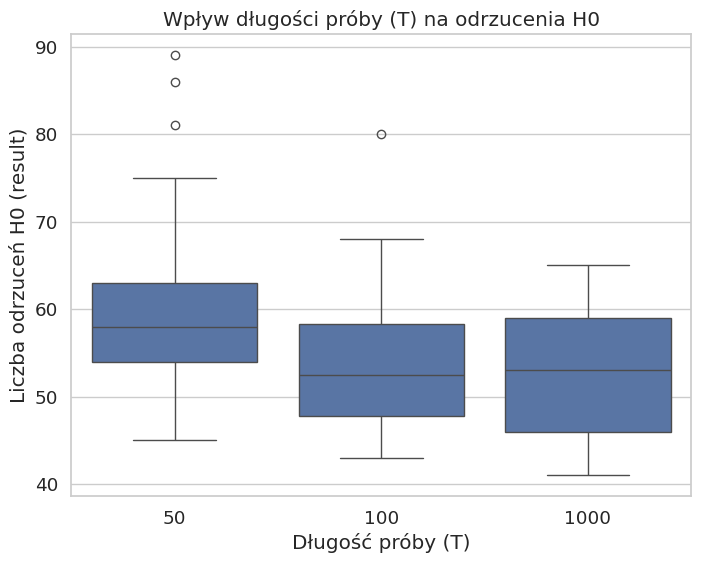

In [91]:
t_group = results_df.groupby('T')['result'].agg(['mean', 'std']).reset_index()
print("Średnia i odchylenie standardowe result w zależności od T:")
print(t_group)

sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(8,6))
sns.boxplot(x='T', y='result', data=results_df)
plt.title("Wpływ długości próby (T) na odrzucenia H0")
plt.xlabel("Długość próby (T)")
plt.ylabel("Liczba odrzuceń H0 (result)")
plt.show()

Wpływ alpha1_x na p_value

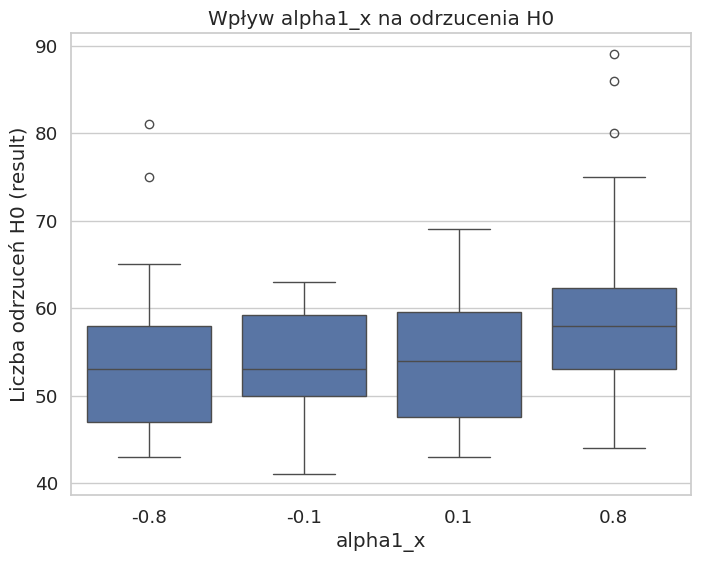

In [92]:
# Wykres pudełkowy dla różnych alpha1_x, pozwoli zobaczyć rozkład p_value.

plt.figure(figsize=(8,6))
sns.boxplot(x='alpha1_x', y='result', data=results_df)
plt.title("Wpływ alpha1_x na odrzucenia H0")
plt.xlabel("alpha1_x")
plt.ylabel("Liczba odrzuceń H0 (result)")
plt.show()

 Wpływ beta1_y na p_value

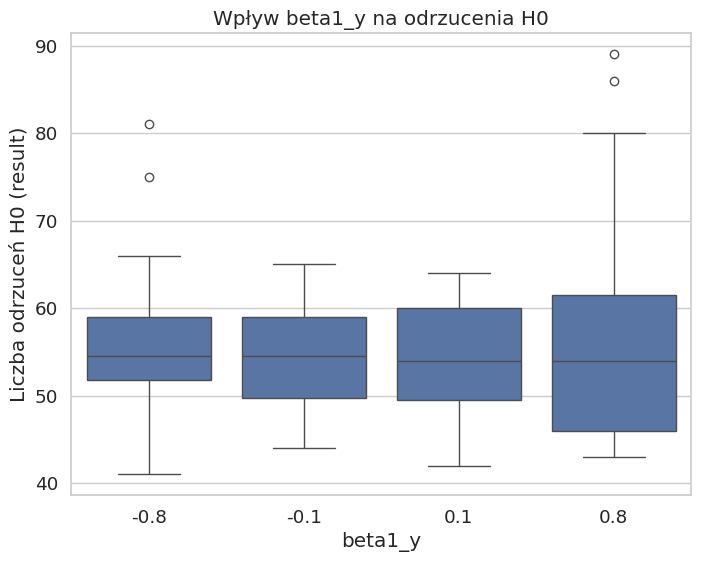

In [93]:
plt.figure(figsize=(8,6))
sns.boxplot(x='beta1_y', y='result', data=results_df)
plt.title("Wpływ beta1_y na odrzucenia H0")
plt.xlabel("beta1_y")
plt.ylabel("Liczba odrzuceń H0 (result)")
plt.show()

Wpływ beta_g na p_value

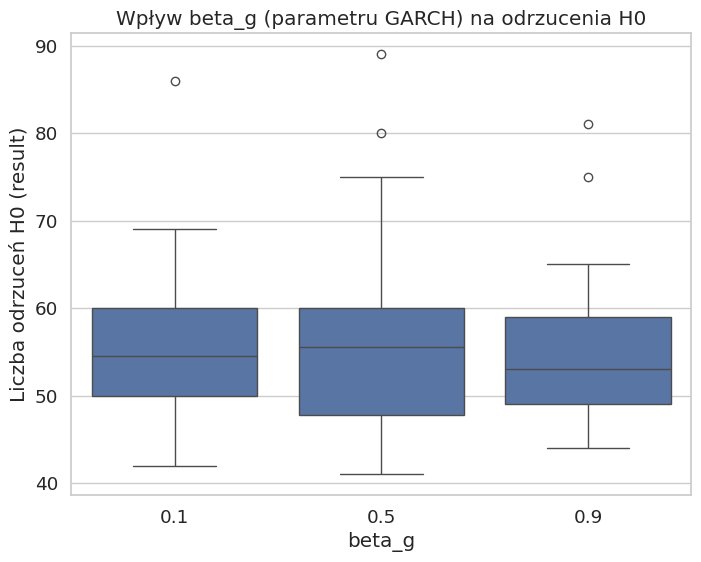

In [94]:
plt.figure(figsize=(8,6))
sns.boxplot(x='beta_g', y='result', data=results_df)
plt.title("Wpływ beta_g (parametru GARCH) na odrzucenia H0")
plt.xlabel("beta_g")
plt.ylabel("Liczba odrzuceń H0 (result)")
plt.show()

# Symulacja z użyciem estymatorów HC

In [7]:
# Funkcja obliczająca macierz kowariancji HC
def compute_hc_covar_x_only(results_fit, hc_type):
    """
     Oblicza macierz kowariancji odpornej na heteroskedastyczność wyłącznie dla równania 'x' w modelu VAR.
    """
    # Reszty dla równania 'x'
    residuals = results_fit.resid['x'].values  # Wektor reszt dla równania x

    # Parametry dla równania 'x'
    params_x = results_fit.params['x']

    # Tworzenie macierzy zmiennych objaśniających (opóźnienia x i y w równaniu x)
    lagged_endog = results_fit.model.endog
    lags = results_fit.k_ar

    # Budowa macierzy X tylko dla równania 'x'
    X = []
    for i in range(lags):
        X.append(lagged_endog[lags - i - 1:-i - 1, :])  # Wszystkie opóźnienia
    X = np.hstack(X)  # Sklejenie opóźnionych kolumn
    X = np.hstack([np.ones((X.shape[0], 1)), X])  # Dodanie kolumny stałej

    # Skalowanie reszt w zależności od HC
    n_obs, n_params = X.shape
    if hc_type == 'HC0':
        scale = np.diagflat(residuals**2)
    elif hc_type == 'HC1':
        scale = np.diagflat(residuals**2 * n_obs / (n_obs - n_params))
    elif hc_type == 'HC2':
        h = np.diag(X @ np.linalg.pinv(X.T @ X) @ X.T)
        scale = np.diagflat(residuals**2 / (1 - h))
    elif hc_type == 'HC3':
        h = np.diag(X @ np.linalg.pinv(X.T @ X) @ X.T)
        scale = np.diagflat(residuals**2 / (1 - h)**2)
    else:
        raise ValueError("Invalid HC type. Choose from 'HC0', 'HC1', 'HC2', 'HC3'.")

    # Obliczanie macierzy kowariancji wyłącznie dla parametrów równania 'x'
    bread = np.linalg.pinv(X.T @ X)  # Odwrotność X'X
    meat = X.T @ scale @ X  # Skalowanie reszt
    cov_matrix = bread @ meat @ bread

    return cov_matrix


In [8]:
# Symulacja z uwzględnieniem HC
results_with_hc = []
hc_methods = ['HC0', 'HC1', 'HC2', 'HC3']

for T in T_values:
    for alpha1 in alpha1_values:
        for beta1 in beta1_values:
            for beta_g in beta_g_values:
                for hc_type in hc_methods:
                    result = 0
                    for _ in range(1000):
                        # 1. Generowanie danych
                        eps_x, _ = generate_garch_resid(T, alpha_g, beta_g)
                        y_full = generate_ar1_normal(T, beta_0, beta1)
                        x_full = generate_ar1(T, alpha_0, alpha1, eps_x)
                        x = x_full[1000:]
                        y = y_full[1000:]

                        # 2. Dopasowanie modelu VAR
                        data = pd.DataFrame({'x': x, 'y': y})
                        model = VAR(data)
                        results_fit = model.fit(maxlags=1, trend='c')

                        # 3. Obliczenie macierzy kowariancji HC tylko dla równania 'x'
                        cov_matrix = compute_hc_covar_x_only(results_fit, hc_type)

                       # Wyodrębnienie błędów standardowych i obliczenie statystyki t
                        params_x = results_fit.params['x']
                        param_value = params_x['L1.y']
                        param_index = list(params_x.index).index('L1.y')
                        param_se = np.sqrt(cov_matrix[param_index, param_index])

                        t_stat = param_value / param_se
                        p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=T - results_fit.df_model))

                        # 5. Sprawdzenie istotności
                        if p_value < 0.05:
                            result += 1

                    # 6. Zapis wyników
                    results_with_hc.append({
                        'T': T,
                        'alpha1_x': alpha1,
                        'beta1_y': beta1,
                        'alpha_g': alpha_g,
                        'beta_g': beta_g,
                        'method': hc_type,
                        'result': result
                    })

# Konwersja wyników do DataFrame
results_with_hc_df = pd.DataFrame(results_with_hc)

In [10]:
print(results_with_hc_df)

        T  alpha1_x  beta1_y  alpha_g  beta_g method  result
0      50      -0.8     -0.8     0.05     0.1    HC0      88
1      50      -0.8     -0.8     0.05     0.1    HC1      86
2      50      -0.8     -0.8     0.05     0.1    HC2      68
3      50      -0.8     -0.8     0.05     0.1    HC3      50
4      50      -0.8     -0.8     0.05     0.5    HC0     102
5      50      -0.8     -0.8     0.05     0.5    HC1      72
6      50      -0.8     -0.8     0.05     0.5    HC2      65
7      50      -0.8     -0.8     0.05     0.5    HC3      55
8      50      -0.8     -0.8     0.05     0.9    HC0      70
9      50      -0.8     -0.8     0.05     0.9    HC1      76
10     50      -0.8     -0.8     0.05     0.9    HC2      71
11     50      -0.8     -0.8     0.05     0.9    HC3      46
12     50      -0.8     -0.1     0.05     0.1    HC0      64
13     50      -0.8     -0.1     0.05     0.1    HC1      75
14     50      -0.8     -0.1     0.05     0.1    HC2      49
15     50      -0.8     

## Porównanie wyników

In [11]:
data = {
    "T": [50] * 48 + [100] * 48 + [1000] * 48,
    "alpha1_x": [-0.8] * 12 + [-0.1] * 12 + [0.1] * 12 + [0.8] * 12 + [-0.8] * 12 + [-0.1] * 12 + [0.1] * 12 + [0.8] * 12 + [-0.8] * 12 + [-0.1] * 12 + [0.1] * 12 + [0.8] * 12,
    "beta1_y": [-0.8, -0.8, -0.8, -0.1, -0.1, -0.1, 0.1, 0.1, 0.1, 0.8, 0.8, 0.8] * 12,
    "alpha_g": [0.05] * 144,
    "beta_g": [0.1, 0.5, 0.9] * 48,
    "result": [
        58, 75, 81, 55, 53, 58, 50, 54, 57, 52, 46, 45, 60, 52, 58, 55, 57, 53, 63, 57, 61, 63, 60, 55, 66, 58, 46, 56, 63, 59,
        54, 50, 63, 69, 59, 58, 49, 65, 58, 58, 46, 65, 63, 60, 60, 86, 89, 75, 55, 60, 53, 44, 47, 45, 61, 47, 50, 43, 45, 45,
        59, 52, 61, 52, 60, 52, 48, 45, 53, 51, 60, 50, 43, 48, 53, 48, 46, 53, 54, 56, 51, 45, 61, 45, 54, 53, 59, 60, 51, 55,
        54, 58, 48, 68, 80, 61, 57, 47, 54, 59, 60, 49, 44, 57, 50, 65, 60, 49, 56, 41, 44, 50, 59, 46, 42, 51, 45, 46, 63, 50,
        44, 54, 51, 62, 45, 63, 64, 43, 61, 54, 54, 44, 52, 55, 64, 54, 56, 53, 60, 62, 45, 53, 44, 50
    ]
}

# Tworzenie DataFrame
results_df = pd.DataFrame(data)

In [12]:
# Przygotowanie listy wyników dla porównania
comparison_results = []

# Iteracja przez wyniki symulacji bez HC
for index, row in results_df.iterrows():
    # Filtr wyników dla tych samych parametrów z HC
    hc_rows = results_with_hc_df[
        (results_with_hc_df['T'] == row['T']) &
        (results_with_hc_df['alpha1_x'] == row['alpha1_x']) &
        (results_with_hc_df['beta1_y'] == row['beta1_y']) &
        (results_with_hc_df['beta_g'] == row['beta_g'])
    ]

    # Dodanie wiersza z wynikami dla porównania
    comparison_results.append({
        'T': row['T'],
        'alpha1_x': row['alpha1_x'],
        'beta1_y': row['beta1_y'],
        'beta_g': row['beta_g'],
        'No_HC': row['result'],
        'HC0': hc_rows[hc_rows['method'] == 'HC0']['result'].values[0] if not hc_rows[hc_rows['method'] == 'HC0'].empty else 0,
        'HC1': hc_rows[hc_rows['method'] == 'HC1']['result'].values[0] if not hc_rows[hc_rows['method'] == 'HC1'].empty else 0,
        'HC2': hc_rows[hc_rows['method'] == 'HC2']['result'].values[0] if not hc_rows[hc_rows['method'] == 'HC2'].empty else 0,
        'HC3': hc_rows[hc_rows['method'] == 'HC3']['result'].values[0] if not hc_rows[hc_rows['method'] == 'HC3'].empty else 0
    })

# Tworzenie DataFrame z wynikami porównawczymi
comparison_df = pd.DataFrame(comparison_results)

# Wyświetlenie wyników
print(comparison_df)

          T  alpha1_x  beta1_y  beta_g  No_HC  HC0  HC1  HC2  HC3
0      50.0      -0.8     -0.8     0.1   58.0   88   86   68   50
1      50.0      -0.8     -0.8     0.5   75.0  102   72   65   55
2      50.0      -0.8     -0.8     0.9   81.0   70   76   71   46
3      50.0      -0.8     -0.1     0.1   55.0   64   75   49   38
4      50.0      -0.8     -0.1     0.5   53.0   59   58   73   57
5      50.0      -0.8     -0.1     0.9   58.0   76   58   49   51
6      50.0      -0.8      0.1     0.1   50.0   80   64   48   43
7      50.0      -0.8      0.1     0.5   54.0   82   69   64   42
8      50.0      -0.8      0.1     0.9   57.0   67   70   54   69
9      50.0      -0.8      0.8     0.1   52.0   56   64   57   49
10     50.0      -0.8      0.8     0.5   46.0   71   68   54   45
11     50.0      -0.8      0.8     0.9   45.0   68   54   48   50
12     50.0      -0.1     -0.8     0.1   60.0   65   69   60   40
13     50.0      -0.1     -0.8     0.5   52.0   69   48   53   49
14     50.

In [13]:
def create_tables(df, variable):
    """
    Tworzy tabelki dla zmiennej `variable`, utrzymując stałe wartości pozostałych zmiennych.
    """
    tables = {}
    fixed_values = {
        'T': df['T'].iloc[0],
        'alpha1_x': df['alpha1_x'].iloc[0],
        'beta1_y': df['beta1_y'].iloc[0],
        'beta_g': df['beta_g'].iloc[0]
    }

    for var, _ in fixed_values.items():
        if var != variable:
            fixed_values[var] = df[var].iloc[0]

    for val in df[variable].unique():
        table = df[df[variable] == val].copy()
        for var, fixed_val in fixed_values.items():
            if var != variable:
                table = table[table[var] == fixed_val]
        tables[val] = table

    return tables

def calculate_averages(tables):
    """
    Oblicza średnie wartości dla każdej tabeli w słowniku `tables`.
    """
    averages = {key: table.mean(numeric_only=True) for key, table in tables.items()}
    return averages

def save_to_excel(df, file_path):
    """
    Zapisuje DataFrame `df` do pliku Excel.
    """
    df.to_excel(file_path, index=False)
    print(f"DataFrame zapisano do pliku: {file_path}")

In [14]:
# Tworzenie tabel dla każdej zmiennej
t_T = create_tables(comparison_df, 'T')
t_alpha1 = create_tables(comparison_df, 'alpha1_x')
t_beta1 = create_tables(comparison_df, 'beta1_y')
t_beta_g = create_tables(comparison_df, 'beta_g')

# Obliczanie średnich wartości dla każdej tabeli
average_T = calculate_averages(t_T)
average_alpha1 = calculate_averages(t_alpha1)
average_beta1 = calculate_averages(t_beta1)
average_beta_g = calculate_averages(t_beta_g)


# Wyświetlenie informacji o średnich wartościach
print("Średnie wartości dla T:", average_T)
print("Średnie wartości dla alpha1_x:", average_alpha1)
print("Średnie wartości dla beta1_y:", average_beta1)
print("Średnie wartości dla beta_g:", average_beta_g)

Średnie wartości dla T: {50.0: T           50.0
alpha1_x    -0.8
beta1_y     -0.8
beta_g       0.1
No_HC       58.0
HC0         88.0
HC1         86.0
HC2         68.0
HC3         50.0
dtype: float64, 100.0: T           100.0
alpha1_x     -0.8
beta1_y      -0.8
beta_g        0.1
No_HC        55.0
HC0          60.0
HC1          60.0
HC2          61.0
HC3          67.0
dtype: float64, 1000.0: T           1000.0
alpha1_x      -0.8
beta1_y       -0.8
beta_g         0.1
No_HC         57.0
HC0           65.0
HC1           44.0
HC2           42.0
HC3           58.0
dtype: float64}
Średnie wartości dla alpha1_x: {-0.8: T           50.0
alpha1_x    -0.8
beta1_y     -0.8
beta_g       0.1
No_HC       58.0
HC0         88.0
HC1         86.0
HC2         68.0
HC3         50.0
dtype: float64, -0.1: T           50.0
alpha1_x    -0.1
beta1_y     -0.8
beta_g       0.1
No_HC       60.0
HC0         65.0
HC1         69.0
HC2         60.0
HC3         40.0
dtype: float64, 0.1: T           50.0
alpha1_x     0.1

In [15]:
print(t_T)

{50.0:       T  alpha1_x  beta1_y  beta_g  No_HC  HC0  HC1  HC2  HC3
0  50.0      -0.8     -0.8     0.1   58.0   88   86   68   50, 100.0:         T  alpha1_x  beta1_y  beta_g  No_HC  HC0  HC1  HC2  HC3
48  100.0      -0.8     -0.8     0.1   55.0   60   60   61   67, 1000.0:          T  alpha1_x  beta1_y  beta_g  No_HC  HC0  HC1  HC2  HC3
96  1000.0      -0.8     -0.8     0.1   57.0   65   44   42   58}


In [16]:
print(t_alpha1)

{-0.8:       T  alpha1_x  beta1_y  beta_g  No_HC  HC0  HC1  HC2  HC3
0  50.0      -0.8     -0.8     0.1   58.0   88   86   68   50, -0.1:        T  alpha1_x  beta1_y  beta_g  No_HC  HC0  HC1  HC2  HC3
12  50.0      -0.1     -0.8     0.1   60.0   65   69   60   40, 0.1:        T  alpha1_x  beta1_y  beta_g  No_HC  HC0  HC1  HC2  HC3
24  50.0       0.1     -0.8     0.1   66.0   71   52   49   48, 0.8:        T  alpha1_x  beta1_y  beta_g  No_HC  HC0  HC1  HC2  HC3
36  50.0       0.8     -0.8     0.1   49.0   59   43   53   51}


In [17]:
print(t_beta1)

{-0.8:       T  alpha1_x  beta1_y  beta_g  No_HC  HC0  HC1  HC2  HC3
0  50.0      -0.8     -0.8     0.1   58.0   88   86   68   50, -0.1:       T  alpha1_x  beta1_y  beta_g  No_HC  HC0  HC1  HC2  HC3
3  50.0      -0.8     -0.1     0.1   55.0   64   75   49   38, 0.1:       T  alpha1_x  beta1_y  beta_g  No_HC  HC0  HC1  HC2  HC3
6  50.0      -0.8      0.1     0.1   50.0   80   64   48   43, 0.8:       T  alpha1_x  beta1_y  beta_g  No_HC  HC0  HC1  HC2  HC3
9  50.0      -0.8      0.8     0.1   52.0   56   64   57   49}


In [18]:
print(t_beta_g)

{0.1:       T  alpha1_x  beta1_y  beta_g  No_HC  HC0  HC1  HC2  HC3
0  50.0      -0.8     -0.8     0.1   58.0   88   86   68   50, 0.5:       T  alpha1_x  beta1_y  beta_g  No_HC  HC0  HC1  HC2  HC3
1  50.0      -0.8     -0.8     0.5   75.0  102   72   65   55, 0.9:       T  alpha1_x  beta1_y  beta_g  No_HC  HC0  HC1  HC2  HC3
2  50.0      -0.8     -0.8     0.9   81.0   70   76   71   46}
